## Does `EnergyModel` actually work for estimation?

The notebook runs a load of automated tests and gets the `EnergyModel` estimation of energy usage, then compares it with the values from energy.json.

In [35]:
from env import TestEnv
import pandas as pd
import json
import os
from conf import LisaLogging
from bart.common.Utils import area_under_curve

LisaLogging.setup()
%matplotlib inline

2017-01-03 18:10:54,380 INFO    : root         : Using LISA logging configuration:
2017-01-03 18:10:54,381 INFO    : root         :   /home/brejac01/sources/lisa/logging.conf


In [3]:
import tests.eas.generic
from tests.eas.generic import EnergyModelTest

## Run all the tests
This will probalby take ages

In [4]:
scs = EnergyModelTest.__subclasses__()

In [5]:
tests = []
for cls in scs:
    t = cls()
    t.setUpClass()
    tests.append(t)

2017-01-03 17:38:00,242 INFO    : LisaTest     : Setup tests execution engine...
2017-01-03 17:38:00,244 INFO    : TestEnv      : Using base path: /home/brejac01/sources/lisa
2017-01-03 17:38:00,245 INFO    : TestEnv      : Loading default (file) target configuration
2017-01-03 17:38:00,246 INFO    : TestEnv      : Loading target configuration [/home/brejac01/sources/lisa/target.config]...
2017-01-03 17:38:00,249 INFO    : TestEnv      : Loading custom (inline) test configuration
2017-01-03 17:38:00,250 INFO    : TestEnv      : Devlib modules to load: ['bl', u'cpuidle', 'cgroups', 'hwmon', 'cpufreq']
2017-01-03 17:38:00,250 INFO    : TestEnv      : Connecting linux target:
2017-01-03 17:38:00,251 INFO    : TestEnv      :   username : brendan
2017-01-03 17:38:00,252 INFO    : TestEnv      :       host : 192.168.2.2
2017-01-03 17:38:00,253 INFO    : TestEnv      :   password : password
2017-01-03 17:38:00,254 INFO    : TestEnv      : Connection settings:
2017-01-03 17:38:00,255 INFO    :

2017-01-03 17:38:56,098 INFO    : Workload     : Workload execution START:
2017-01-03 17:38:56,099 INFO    : Workload     :    /home/brendan/devlib-target/bin/rt-app /home/brendan/devlib-target/run_dir/one_small_00.json 2>&1
2017-01-03 17:39:08,206 INFO    : Executor     : Collected FTrace binary trace:
2017-01-03 17:39:08,207 INFO    : Executor     :    <res_dir>/rtapp:energy_aware:one_small/1/trace.dat
2017-01-03 17:39:08,209 INFO    : Executor     : Collected FTrace function profiling:
2017-01-03 17:39:08,210 INFO    : Executor     :    <res_dir>/rtapp:energy_aware:one_small/1/trace_stat.json
2017-01-03 17:39:08,212 INFO    : Executor     : --------------------------------------------------------------------------------
2017-01-03 17:39:08,214 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-01-03 17:39:08,215 INFO    : Executor     : Experiment 1/5, [energy_aware:one_small] 2/5
2017-01-03 17:39:08,223 WARNING : Executor 

2017-01-03 17:39:16,105 INFO    : Workload     : Workload execution START:
2017-01-03 17:39:16,106 INFO    : Workload     :    /home/brendan/devlib-target/bin/rt-app /home/brendan/devlib-target/run_dir/one_small_00.json 2>&1
2017-01-03 17:39:28,206 INFO    : Executor     : Collected FTrace binary trace:
2017-01-03 17:39:28,208 INFO    : Executor     :    <res_dir>/rtapp:energy_aware:one_small/2/trace.dat
2017-01-03 17:39:28,209 INFO    : Executor     : Collected FTrace function profiling:
2017-01-03 17:39:28,211 INFO    : Executor     :    <res_dir>/rtapp:energy_aware:one_small/2/trace_stat.json
2017-01-03 17:39:28,212 INFO    : Executor     : --------------------------------------------------------------------------------
2017-01-03 17:39:28,214 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-01-03 17:39:28,216 INFO    : Executor     : Experiment 2/5, [energy_aware:one_small] 3/5
2017-01-03 17:39:28,223 WARNING : Executor 

2017-01-03 17:39:36,093 INFO    : Workload     : Workload execution START:
2017-01-03 17:39:36,094 INFO    : Workload     :    /home/brendan/devlib-target/bin/rt-app /home/brendan/devlib-target/run_dir/one_small_00.json 2>&1
2017-01-03 17:39:48,224 INFO    : Executor     : Collected FTrace binary trace:
2017-01-03 17:39:48,226 INFO    : Executor     :    <res_dir>/rtapp:energy_aware:one_small/3/trace.dat
2017-01-03 17:39:48,227 INFO    : Executor     : Collected FTrace function profiling:
2017-01-03 17:39:48,228 INFO    : Executor     :    <res_dir>/rtapp:energy_aware:one_small/3/trace_stat.json
2017-01-03 17:39:48,229 INFO    : Executor     : --------------------------------------------------------------------------------
2017-01-03 17:39:48,230 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-01-03 17:39:48,231 INFO    : Executor     : Experiment 3/5, [energy_aware:one_small] 4/5
2017-01-03 17:39:48,237 WARNING : Executor 

2017-01-03 17:39:56,164 INFO    : Workload     : Workload execution START:
2017-01-03 17:39:56,165 INFO    : Workload     :    /home/brendan/devlib-target/bin/rt-app /home/brendan/devlib-target/run_dir/one_small_00.json 2>&1
2017-01-03 17:40:08,254 INFO    : Executor     : Collected FTrace binary trace:
2017-01-03 17:40:08,256 INFO    : Executor     :    <res_dir>/rtapp:energy_aware:one_small/4/trace.dat
2017-01-03 17:40:08,258 INFO    : Executor     : Collected FTrace function profiling:
2017-01-03 17:40:08,259 INFO    : Executor     :    <res_dir>/rtapp:energy_aware:one_small/4/trace_stat.json
2017-01-03 17:40:08,260 INFO    : Executor     : --------------------------------------------------------------------------------
2017-01-03 17:40:08,261 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-01-03 17:40:08,262 INFO    : Executor     : Experiment 4/5, [energy_aware:one_small] 5/5
2017-01-03 17:40:08,269 WARNING : Executor 

2017-01-03 17:40:16,127 INFO    : Workload     : Workload execution START:
2017-01-03 17:40:16,128 INFO    : Workload     :    /home/brendan/devlib-target/bin/rt-app /home/brendan/devlib-target/run_dir/one_small_00.json 2>&1
2017-01-03 17:40:28,576 INFO    : Executor     : Collected FTrace binary trace:
2017-01-03 17:40:28,578 INFO    : Executor     :    <res_dir>/rtapp:energy_aware:one_small/5/trace.dat
2017-01-03 17:40:28,579 INFO    : Executor     : Collected FTrace function profiling:
2017-01-03 17:40:28,580 INFO    : Executor     :    <res_dir>/rtapp:energy_aware:one_small/5/trace_stat.json
2017-01-03 17:40:28,581 INFO    : Executor     : --------------------------------------------------------------------------------
2017-01-03 17:40:28,582 INFO    : Executor     : 
2017-01-03 17:40:28,583 INFO    : Executor     : ################################################################################
2017-01-03 17:40:28,584 INFO    : Executor     : Experiments execution completed
2017-0

2017-01-03 17:40:41,171 INFO    : Workload     : Workload execution START:
2017-01-03 17:40:41,173 INFO    : Workload     :    /home/brendan/devlib-target/bin/rt-app /home/brendan/devlib-target/run_dir/three_small_00.json 2>&1
2017-01-03 17:40:53,750 INFO    : Executor     : Collected FTrace binary trace:
2017-01-03 17:40:53,752 INFO    : Executor     :    <res_dir>/rtapp:energy_aware:three_small/1/trace.dat
2017-01-03 17:40:53,753 INFO    : Executor     : Collected FTrace function profiling:
2017-01-03 17:40:53,754 INFO    : Executor     :    <res_dir>/rtapp:energy_aware:three_small/1/trace_stat.json
2017-01-03 17:40:53,755 INFO    : Executor     : --------------------------------------------------------------------------------
2017-01-03 17:40:53,757 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-01-03 17:40:53,758 INFO    : Executor     : Experiment 1/5, [energy_aware:three_small] 2/5
2017-01-03 17:40:53,765 WARNING : E

2017-01-03 17:41:01,609 INFO    : Workload     : Workload execution START:
2017-01-03 17:41:01,610 INFO    : Workload     :    /home/brendan/devlib-target/bin/rt-app /home/brendan/devlib-target/run_dir/three_small_00.json 2>&1
2017-01-03 17:41:14,111 INFO    : Executor     : Collected FTrace binary trace:
2017-01-03 17:41:14,113 INFO    : Executor     :    <res_dir>/rtapp:energy_aware:three_small/2/trace.dat
2017-01-03 17:41:14,114 INFO    : Executor     : Collected FTrace function profiling:
2017-01-03 17:41:14,115 INFO    : Executor     :    <res_dir>/rtapp:energy_aware:three_small/2/trace_stat.json
2017-01-03 17:41:14,116 INFO    : Executor     : --------------------------------------------------------------------------------
2017-01-03 17:41:14,117 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-01-03 17:41:14,118 INFO    : Executor     : Experiment 2/5, [energy_aware:three_small] 3/5
2017-01-03 17:41:14,126 WARNING : E

2017-01-03 17:41:21,989 INFO    : Workload     : Workload execution START:
2017-01-03 17:41:21,990 INFO    : Workload     :    /home/brendan/devlib-target/bin/rt-app /home/brendan/devlib-target/run_dir/three_small_00.json 2>&1
2017-01-03 17:41:35,014 INFO    : Executor     : Collected FTrace binary trace:
2017-01-03 17:41:35,016 INFO    : Executor     :    <res_dir>/rtapp:energy_aware:three_small/3/trace.dat
2017-01-03 17:41:35,017 INFO    : Executor     : Collected FTrace function profiling:
2017-01-03 17:41:35,019 INFO    : Executor     :    <res_dir>/rtapp:energy_aware:three_small/3/trace_stat.json
2017-01-03 17:41:35,020 INFO    : Executor     : --------------------------------------------------------------------------------
2017-01-03 17:41:35,021 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-01-03 17:41:35,022 INFO    : Executor     : Experiment 3/5, [energy_aware:three_small] 4/5
2017-01-03 17:41:35,030 WARNING : E

2017-01-03 17:41:42,975 INFO    : Workload     : Workload execution START:
2017-01-03 17:41:42,976 INFO    : Workload     :    /home/brendan/devlib-target/bin/rt-app /home/brendan/devlib-target/run_dir/three_small_00.json 2>&1
2017-01-03 17:41:55,461 INFO    : Executor     : Collected FTrace binary trace:
2017-01-03 17:41:55,463 INFO    : Executor     :    <res_dir>/rtapp:energy_aware:three_small/4/trace.dat
2017-01-03 17:41:55,464 INFO    : Executor     : Collected FTrace function profiling:
2017-01-03 17:41:55,465 INFO    : Executor     :    <res_dir>/rtapp:energy_aware:three_small/4/trace_stat.json
2017-01-03 17:41:55,466 INFO    : Executor     : --------------------------------------------------------------------------------
2017-01-03 17:41:55,468 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-01-03 17:41:55,469 INFO    : Executor     : Experiment 4/5, [energy_aware:three_small] 5/5
2017-01-03 17:41:55,476 WARNING : E

2017-01-03 17:42:03,356 INFO    : Workload     : Workload execution START:
2017-01-03 17:42:03,357 INFO    : Workload     :    /home/brendan/devlib-target/bin/rt-app /home/brendan/devlib-target/run_dir/three_small_00.json 2>&1
2017-01-03 17:42:15,932 INFO    : Executor     : Collected FTrace binary trace:
2017-01-03 17:42:15,934 INFO    : Executor     :    <res_dir>/rtapp:energy_aware:three_small/5/trace.dat
2017-01-03 17:42:15,935 INFO    : Executor     : Collected FTrace function profiling:
2017-01-03 17:42:15,936 INFO    : Executor     :    <res_dir>/rtapp:energy_aware:three_small/5/trace_stat.json
2017-01-03 17:42:15,937 INFO    : Executor     : --------------------------------------------------------------------------------
2017-01-03 17:42:15,938 INFO    : Executor     : 
2017-01-03 17:42:15,939 INFO    : Executor     : ################################################################################
2017-01-03 17:42:15,941 INFO    : Executor     : Experiments execution completed


2017-01-03 17:42:28,418 INFO    : Workload     : Workload execution START:
2017-01-03 17:42:28,419 INFO    : Workload     :    /home/brendan/devlib-target/bin/rt-app /home/brendan/devlib-target/run_dir/two_big_00.json 2>&1
2017-01-03 17:42:40,663 INFO    : Executor     : Collected FTrace binary trace:
2017-01-03 17:42:40,665 INFO    : Executor     :    <res_dir>/rtapp:energy_aware:two_big/1/trace.dat
2017-01-03 17:42:40,666 INFO    : Executor     : Collected FTrace function profiling:
2017-01-03 17:42:40,667 INFO    : Executor     :    <res_dir>/rtapp:energy_aware:two_big/1/trace_stat.json
2017-01-03 17:42:40,668 INFO    : Executor     : --------------------------------------------------------------------------------
2017-01-03 17:42:40,670 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-01-03 17:42:40,671 INFO    : Executor     : Experiment 1/5, [energy_aware:two_big] 2/5
2017-01-03 17:42:40,678 WARNING : Executor     : FT

2017-01-03 17:42:48,519 INFO    : Workload     : Workload execution START:
2017-01-03 17:42:48,520 INFO    : Workload     :    /home/brendan/devlib-target/bin/rt-app /home/brendan/devlib-target/run_dir/two_big_00.json 2>&1
2017-01-03 17:43:00,877 INFO    : Executor     : Collected FTrace binary trace:
2017-01-03 17:43:00,879 INFO    : Executor     :    <res_dir>/rtapp:energy_aware:two_big/2/trace.dat
2017-01-03 17:43:00,881 INFO    : Executor     : Collected FTrace function profiling:
2017-01-03 17:43:00,882 INFO    : Executor     :    <res_dir>/rtapp:energy_aware:two_big/2/trace_stat.json
2017-01-03 17:43:00,883 INFO    : Executor     : --------------------------------------------------------------------------------
2017-01-03 17:43:00,884 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-01-03 17:43:00,885 INFO    : Executor     : Experiment 2/5, [energy_aware:two_big] 3/5
2017-01-03 17:43:00,893 WARNING : Executor     : FT

2017-01-03 17:43:08,731 INFO    : Workload     : Workload execution START:
2017-01-03 17:43:08,732 INFO    : Workload     :    /home/brendan/devlib-target/bin/rt-app /home/brendan/devlib-target/run_dir/two_big_00.json 2>&1
2017-01-03 17:43:21,038 INFO    : Executor     : Collected FTrace binary trace:
2017-01-03 17:43:21,040 INFO    : Executor     :    <res_dir>/rtapp:energy_aware:two_big/3/trace.dat
2017-01-03 17:43:21,041 INFO    : Executor     : Collected FTrace function profiling:
2017-01-03 17:43:21,042 INFO    : Executor     :    <res_dir>/rtapp:energy_aware:two_big/3/trace_stat.json
2017-01-03 17:43:21,043 INFO    : Executor     : --------------------------------------------------------------------------------
2017-01-03 17:43:21,045 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-01-03 17:43:21,046 INFO    : Executor     : Experiment 3/5, [energy_aware:two_big] 4/5
2017-01-03 17:43:21,053 WARNING : Executor     : FT

2017-01-03 17:43:28,928 INFO    : Workload     : Workload execution START:
2017-01-03 17:43:28,929 INFO    : Workload     :    /home/brendan/devlib-target/bin/rt-app /home/brendan/devlib-target/run_dir/two_big_00.json 2>&1
2017-01-03 17:43:41,261 INFO    : Executor     : Collected FTrace binary trace:
2017-01-03 17:43:41,263 INFO    : Executor     :    <res_dir>/rtapp:energy_aware:two_big/4/trace.dat
2017-01-03 17:43:41,264 INFO    : Executor     : Collected FTrace function profiling:
2017-01-03 17:43:41,265 INFO    : Executor     :    <res_dir>/rtapp:energy_aware:two_big/4/trace_stat.json
2017-01-03 17:43:41,266 INFO    : Executor     : --------------------------------------------------------------------------------
2017-01-03 17:43:41,268 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-01-03 17:43:41,269 INFO    : Executor     : Experiment 4/5, [energy_aware:two_big] 5/5
2017-01-03 17:43:41,276 WARNING : Executor     : FT

2017-01-03 17:43:49,128 INFO    : Workload     : Workload execution START:
2017-01-03 17:43:49,129 INFO    : Workload     :    /home/brendan/devlib-target/bin/rt-app /home/brendan/devlib-target/run_dir/two_big_00.json 2>&1
2017-01-03 17:44:01,351 INFO    : Executor     : Collected FTrace binary trace:
2017-01-03 17:44:01,353 INFO    : Executor     :    <res_dir>/rtapp:energy_aware:two_big/5/trace.dat
2017-01-03 17:44:01,354 INFO    : Executor     : Collected FTrace function profiling:
2017-01-03 17:44:01,356 INFO    : Executor     :    <res_dir>/rtapp:energy_aware:two_big/5/trace_stat.json
2017-01-03 17:44:01,357 INFO    : Executor     : --------------------------------------------------------------------------------
2017-01-03 17:44:01,359 INFO    : Executor     : 
2017-01-03 17:44:01,360 INFO    : Executor     : ################################################################################
2017-01-03 17:44:01,361 INFO    : Executor     : Experiments execution completed
2017-01-03 1

2017-01-03 17:44:13,917 INFO    : Workload     : Workload execution START:
2017-01-03 17:44:13,919 INFO    : Workload     :    /home/brendan/devlib-target/bin/rt-app /home/brendan/devlib-target/run_dir/two_big_three_small_00.json 2>&1
2017-01-03 17:44:28,481 INFO    : Executor     : Collected FTrace binary trace:
2017-01-03 17:44:28,483 INFO    : Executor     :    <res_dir>/rtapp:energy_aware:two_big_three_small/1/trace.dat
2017-01-03 17:44:28,484 INFO    : Executor     : Collected FTrace function profiling:
2017-01-03 17:44:28,485 INFO    : Executor     :    <res_dir>/rtapp:energy_aware:two_big_three_small/1/trace_stat.json
2017-01-03 17:44:28,487 INFO    : Executor     : --------------------------------------------------------------------------------
2017-01-03 17:44:28,488 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-01-03 17:44:28,489 INFO    : Executor     : Experiment 1/5, [energy_aware:two_big_three_small] 2/5
201

2017-01-03 17:44:36,356 INFO    : Workload     : Workload execution START:
2017-01-03 17:44:36,357 INFO    : Workload     :    /home/brendan/devlib-target/bin/rt-app /home/brendan/devlib-target/run_dir/two_big_three_small_00.json 2>&1
2017-01-03 17:44:49,237 INFO    : Executor     : Collected FTrace binary trace:
2017-01-03 17:44:49,239 INFO    : Executor     :    <res_dir>/rtapp:energy_aware:two_big_three_small/2/trace.dat
2017-01-03 17:44:49,240 INFO    : Executor     : Collected FTrace function profiling:
2017-01-03 17:44:49,241 INFO    : Executor     :    <res_dir>/rtapp:energy_aware:two_big_three_small/2/trace_stat.json
2017-01-03 17:44:49,242 INFO    : Executor     : --------------------------------------------------------------------------------
2017-01-03 17:44:49,243 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-01-03 17:44:49,244 INFO    : Executor     : Experiment 2/5, [energy_aware:two_big_three_small] 3/5
201

2017-01-03 17:44:57,100 INFO    : Workload     : Workload execution START:
2017-01-03 17:44:57,101 INFO    : Workload     :    /home/brendan/devlib-target/bin/rt-app /home/brendan/devlib-target/run_dir/two_big_three_small_00.json 2>&1
2017-01-03 17:45:10,065 INFO    : Executor     : Collected FTrace binary trace:
2017-01-03 17:45:10,067 INFO    : Executor     :    <res_dir>/rtapp:energy_aware:two_big_three_small/3/trace.dat
2017-01-03 17:45:10,069 INFO    : Executor     : Collected FTrace function profiling:
2017-01-03 17:45:10,070 INFO    : Executor     :    <res_dir>/rtapp:energy_aware:two_big_three_small/3/trace_stat.json
2017-01-03 17:45:10,072 INFO    : Executor     : --------------------------------------------------------------------------------
2017-01-03 17:45:10,074 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-01-03 17:45:10,075 INFO    : Executor     : Experiment 3/5, [energy_aware:two_big_three_small] 4/5
201

2017-01-03 17:45:17,945 INFO    : Workload     : Workload execution START:
2017-01-03 17:45:17,946 INFO    : Workload     :    /home/brendan/devlib-target/bin/rt-app /home/brendan/devlib-target/run_dir/two_big_three_small_00.json 2>&1
2017-01-03 17:45:30,882 INFO    : Executor     : Collected FTrace binary trace:
2017-01-03 17:45:30,883 INFO    : Executor     :    <res_dir>/rtapp:energy_aware:two_big_three_small/4/trace.dat
2017-01-03 17:45:30,885 INFO    : Executor     : Collected FTrace function profiling:
2017-01-03 17:45:30,886 INFO    : Executor     :    <res_dir>/rtapp:energy_aware:two_big_three_small/4/trace_stat.json
2017-01-03 17:45:30,888 INFO    : Executor     : --------------------------------------------------------------------------------
2017-01-03 17:45:30,889 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-01-03 17:45:30,891 INFO    : Executor     : Experiment 4/5, [energy_aware:two_big_three_small] 5/5
201

2017-01-03 17:45:38,839 INFO    : Workload     : Workload execution START:
2017-01-03 17:45:38,840 INFO    : Workload     :    /home/brendan/devlib-target/bin/rt-app /home/brendan/devlib-target/run_dir/two_big_three_small_00.json 2>&1
2017-01-03 17:45:51,754 INFO    : Executor     : Collected FTrace binary trace:
2017-01-03 17:45:51,755 INFO    : Executor     :    <res_dir>/rtapp:energy_aware:two_big_three_small/5/trace.dat
2017-01-03 17:45:51,756 INFO    : Executor     : Collected FTrace function profiling:
2017-01-03 17:45:51,758 INFO    : Executor     :    <res_dir>/rtapp:energy_aware:two_big_three_small/5/trace_stat.json
2017-01-03 17:45:51,759 INFO    : Executor     : --------------------------------------------------------------------------------
2017-01-03 17:45:51,761 INFO    : Executor     : 
2017-01-03 17:45:51,762 INFO    : Executor     : ################################################################################
2017-01-03 17:45:51,764 INFO    : Executor     : Experime

2017-01-03 17:46:04,352 INFO    : Workload     : Workload execution START:
2017-01-03 17:46:04,353 INFO    : Workload     :    /home/brendan/devlib-target/bin/rt-app /home/brendan/devlib-target/run_dir/ramp_up_00.json 2>&1
2017-01-03 17:46:39,522 INFO    : Executor     : Collected FTrace binary trace:
2017-01-03 17:46:39,524 INFO    : Executor     :    <res_dir>/rtapp:energy_aware:ramp_up/1/trace.dat
2017-01-03 17:46:39,525 INFO    : Executor     : Collected FTrace function profiling:
2017-01-03 17:46:39,527 INFO    : Executor     :    <res_dir>/rtapp:energy_aware:ramp_up/1/trace_stat.json
2017-01-03 17:46:39,529 INFO    : Executor     : --------------------------------------------------------------------------------
2017-01-03 17:46:39,530 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-01-03 17:46:39,532 INFO    : Executor     : Experiment 1/5, [energy_aware:ramp_up] 2/5
2017-01-03 17:46:39,540 WARNING : Executor     : FT

2017-01-03 17:46:47,428 INFO    : Workload     : Workload execution START:
2017-01-03 17:46:47,430 INFO    : Workload     :    /home/brendan/devlib-target/bin/rt-app /home/brendan/devlib-target/run_dir/ramp_up_00.json 2>&1
2017-01-03 17:47:22,707 INFO    : Executor     : Collected FTrace binary trace:
2017-01-03 17:47:22,709 INFO    : Executor     :    <res_dir>/rtapp:energy_aware:ramp_up/2/trace.dat
2017-01-03 17:47:22,710 INFO    : Executor     : Collected FTrace function profiling:
2017-01-03 17:47:22,711 INFO    : Executor     :    <res_dir>/rtapp:energy_aware:ramp_up/2/trace_stat.json
2017-01-03 17:47:22,713 INFO    : Executor     : --------------------------------------------------------------------------------
2017-01-03 17:47:22,714 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-01-03 17:47:22,715 INFO    : Executor     : Experiment 2/5, [energy_aware:ramp_up] 3/5
2017-01-03 17:47:22,724 WARNING : Executor     : FT

2017-01-03 17:47:30,648 INFO    : Workload     : Workload execution START:
2017-01-03 17:47:30,649 INFO    : Workload     :    /home/brendan/devlib-target/bin/rt-app /home/brendan/devlib-target/run_dir/ramp_up_00.json 2>&1
2017-01-03 17:48:05,892 INFO    : Executor     : Collected FTrace binary trace:
2017-01-03 17:48:05,894 INFO    : Executor     :    <res_dir>/rtapp:energy_aware:ramp_up/3/trace.dat
2017-01-03 17:48:05,895 INFO    : Executor     : Collected FTrace function profiling:
2017-01-03 17:48:05,896 INFO    : Executor     :    <res_dir>/rtapp:energy_aware:ramp_up/3/trace_stat.json
2017-01-03 17:48:05,897 INFO    : Executor     : --------------------------------------------------------------------------------
2017-01-03 17:48:05,898 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-01-03 17:48:05,900 INFO    : Executor     : Experiment 3/5, [energy_aware:ramp_up] 4/5
2017-01-03 17:48:05,907 WARNING : Executor     : FT

2017-01-03 17:48:13,807 INFO    : Workload     : Workload execution START:
2017-01-03 17:48:13,808 INFO    : Workload     :    /home/brendan/devlib-target/bin/rt-app /home/brendan/devlib-target/run_dir/ramp_up_00.json 2>&1
2017-01-03 17:48:49,268 INFO    : Executor     : Collected FTrace binary trace:
2017-01-03 17:48:49,270 INFO    : Executor     :    <res_dir>/rtapp:energy_aware:ramp_up/4/trace.dat
2017-01-03 17:48:49,271 INFO    : Executor     : Collected FTrace function profiling:
2017-01-03 17:48:49,272 INFO    : Executor     :    <res_dir>/rtapp:energy_aware:ramp_up/4/trace_stat.json
2017-01-03 17:48:49,273 INFO    : Executor     : --------------------------------------------------------------------------------
2017-01-03 17:48:49,274 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-01-03 17:48:49,275 INFO    : Executor     : Experiment 4/5, [energy_aware:ramp_up] 5/5
2017-01-03 17:48:49,282 WARNING : Executor     : FT

2017-01-03 17:48:57,197 INFO    : Workload     : Workload execution START:
2017-01-03 17:48:57,198 INFO    : Workload     :    /home/brendan/devlib-target/bin/rt-app /home/brendan/devlib-target/run_dir/ramp_up_00.json 2>&1
2017-01-03 17:49:32,471 INFO    : Executor     : Collected FTrace binary trace:
2017-01-03 17:49:32,473 INFO    : Executor     :    <res_dir>/rtapp:energy_aware:ramp_up/5/trace.dat
2017-01-03 17:49:32,474 INFO    : Executor     : Collected FTrace function profiling:
2017-01-03 17:49:32,475 INFO    : Executor     :    <res_dir>/rtapp:energy_aware:ramp_up/5/trace_stat.json
2017-01-03 17:49:32,476 INFO    : Executor     : --------------------------------------------------------------------------------
2017-01-03 17:49:32,477 INFO    : Executor     : 
2017-01-03 17:49:32,478 INFO    : Executor     : ################################################################################
2017-01-03 17:49:32,479 INFO    : Executor     : Experiments execution completed
2017-01-03 1

2017-01-03 17:49:45,026 INFO    : Workload     : Workload execution START:
2017-01-03 17:49:45,028 INFO    : Workload     :    /home/brendan/devlib-target/bin/rt-app /home/brendan/devlib-target/run_dir/ramp_down_00.json 2>&1
2017-01-03 17:50:20,271 INFO    : Executor     : Collected FTrace binary trace:
2017-01-03 17:50:20,273 INFO    : Executor     :    <res_dir>/rtapp:energy_aware:ramp_down/1/trace.dat
2017-01-03 17:50:20,274 INFO    : Executor     : Collected FTrace function profiling:
2017-01-03 17:50:20,275 INFO    : Executor     :    <res_dir>/rtapp:energy_aware:ramp_down/1/trace_stat.json
2017-01-03 17:50:20,276 INFO    : Executor     : --------------------------------------------------------------------------------
2017-01-03 17:50:20,277 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-01-03 17:50:20,279 INFO    : Executor     : Experiment 1/5, [energy_aware:ramp_down] 2/5
2017-01-03 17:50:20,286 WARNING : Executor 

2017-01-03 17:50:28,148 INFO    : Workload     : Workload execution START:
2017-01-03 17:50:28,149 INFO    : Workload     :    /home/brendan/devlib-target/bin/rt-app /home/brendan/devlib-target/run_dir/ramp_down_00.json 2>&1
2017-01-03 17:51:03,347 INFO    : Executor     : Collected FTrace binary trace:
2017-01-03 17:51:03,349 INFO    : Executor     :    <res_dir>/rtapp:energy_aware:ramp_down/2/trace.dat
2017-01-03 17:51:03,350 INFO    : Executor     : Collected FTrace function profiling:
2017-01-03 17:51:03,351 INFO    : Executor     :    <res_dir>/rtapp:energy_aware:ramp_down/2/trace_stat.json
2017-01-03 17:51:03,353 INFO    : Executor     : --------------------------------------------------------------------------------
2017-01-03 17:51:03,354 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-01-03 17:51:03,355 INFO    : Executor     : Experiment 2/5, [energy_aware:ramp_down] 3/5
2017-01-03 17:51:03,362 WARNING : Executor 

2017-01-03 17:51:11,429 INFO    : Workload     : Workload execution START:
2017-01-03 17:51:11,430 INFO    : Workload     :    /home/brendan/devlib-target/bin/rt-app /home/brendan/devlib-target/run_dir/ramp_down_00.json 2>&1
2017-01-03 17:51:46,653 INFO    : Executor     : Collected FTrace binary trace:
2017-01-03 17:51:46,654 INFO    : Executor     :    <res_dir>/rtapp:energy_aware:ramp_down/3/trace.dat
2017-01-03 17:51:46,655 INFO    : Executor     : Collected FTrace function profiling:
2017-01-03 17:51:46,656 INFO    : Executor     :    <res_dir>/rtapp:energy_aware:ramp_down/3/trace_stat.json
2017-01-03 17:51:46,657 INFO    : Executor     : --------------------------------------------------------------------------------
2017-01-03 17:51:46,657 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-01-03 17:51:46,658 INFO    : Executor     : Experiment 3/5, [energy_aware:ramp_down] 4/5
2017-01-03 17:51:46,665 WARNING : Executor 

2017-01-03 17:51:54,515 INFO    : Workload     : Workload execution START:
2017-01-03 17:51:54,516 INFO    : Workload     :    /home/brendan/devlib-target/bin/rt-app /home/brendan/devlib-target/run_dir/ramp_down_00.json 2>&1
2017-01-03 17:52:29,733 INFO    : Executor     : Collected FTrace binary trace:
2017-01-03 17:52:29,735 INFO    : Executor     :    <res_dir>/rtapp:energy_aware:ramp_down/4/trace.dat
2017-01-03 17:52:29,736 INFO    : Executor     : Collected FTrace function profiling:
2017-01-03 17:52:29,737 INFO    : Executor     :    <res_dir>/rtapp:energy_aware:ramp_down/4/trace_stat.json
2017-01-03 17:52:29,738 INFO    : Executor     : --------------------------------------------------------------------------------
2017-01-03 17:52:29,740 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-01-03 17:52:29,741 INFO    : Executor     : Experiment 4/5, [energy_aware:ramp_down] 5/5
2017-01-03 17:52:29,748 WARNING : Executor 

2017-01-03 17:52:37,583 INFO    : Workload     : Workload execution START:
2017-01-03 17:52:37,584 INFO    : Workload     :    /home/brendan/devlib-target/bin/rt-app /home/brendan/devlib-target/run_dir/ramp_down_00.json 2>&1
2017-01-03 17:53:12,874 INFO    : Executor     : Collected FTrace binary trace:
2017-01-03 17:53:12,876 INFO    : Executor     :    <res_dir>/rtapp:energy_aware:ramp_down/5/trace.dat
2017-01-03 17:53:12,877 INFO    : Executor     : Collected FTrace function profiling:
2017-01-03 17:53:12,878 INFO    : Executor     :    <res_dir>/rtapp:energy_aware:ramp_down/5/trace_stat.json
2017-01-03 17:53:12,879 INFO    : Executor     : --------------------------------------------------------------------------------
2017-01-03 17:53:12,880 INFO    : Executor     : 
2017-01-03 17:53:12,881 INFO    : Executor     : ################################################################################
2017-01-03 17:53:12,882 INFO    : Executor     : Experiments execution completed
2017-0

2017-01-03 17:53:25,404 INFO    : Workload     : Workload execution START:
2017-01-03 17:53:25,405 INFO    : Workload     :    /home/brendan/devlib-target/bin/rt-app /home/brendan/devlib-target/run_dir/wake_migration_00.json 2>&1
2017-01-03 17:53:36,771 INFO    : Executor     : Collected FTrace binary trace:
2017-01-03 17:53:36,773 INFO    : Executor     :    <res_dir>/rtapp:energy_aware:wake_migration/1/trace.dat
2017-01-03 17:53:36,774 INFO    : Executor     : Collected FTrace function profiling:
2017-01-03 17:53:36,775 INFO    : Executor     :    <res_dir>/rtapp:energy_aware:wake_migration/1/trace_stat.json
2017-01-03 17:53:36,776 INFO    : Executor     : --------------------------------------------------------------------------------
2017-01-03 17:53:36,777 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-01-03 17:53:36,779 INFO    : Executor     : Experiment 1/5, [energy_aware:wake_migration] 2/5
2017-01-03 17:53:36,786

2017-01-03 17:53:44,688 INFO    : Workload     : Workload execution START:
2017-01-03 17:53:44,689 INFO    : Workload     :    /home/brendan/devlib-target/bin/rt-app /home/brendan/devlib-target/run_dir/wake_migration_00.json 2>&1
2017-01-03 17:53:55,964 INFO    : Executor     : Collected FTrace binary trace:
2017-01-03 17:53:55,966 INFO    : Executor     :    <res_dir>/rtapp:energy_aware:wake_migration/2/trace.dat
2017-01-03 17:53:55,967 INFO    : Executor     : Collected FTrace function profiling:
2017-01-03 17:53:55,969 INFO    : Executor     :    <res_dir>/rtapp:energy_aware:wake_migration/2/trace_stat.json
2017-01-03 17:53:55,970 INFO    : Executor     : --------------------------------------------------------------------------------
2017-01-03 17:53:55,971 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-01-03 17:53:55,972 INFO    : Executor     : Experiment 2/5, [energy_aware:wake_migration] 3/5
2017-01-03 17:53:55,979

2017-01-03 17:54:03,837 INFO    : Workload     : Workload execution START:
2017-01-03 17:54:03,838 INFO    : Workload     :    /home/brendan/devlib-target/bin/rt-app /home/brendan/devlib-target/run_dir/wake_migration_00.json 2>&1
2017-01-03 17:54:16,309 INFO    : Executor     : Collected FTrace binary trace:
2017-01-03 17:54:16,311 INFO    : Executor     :    <res_dir>/rtapp:energy_aware:wake_migration/3/trace.dat
2017-01-03 17:54:16,312 INFO    : Executor     : Collected FTrace function profiling:
2017-01-03 17:54:16,313 INFO    : Executor     :    <res_dir>/rtapp:energy_aware:wake_migration/3/trace_stat.json
2017-01-03 17:54:16,315 INFO    : Executor     : --------------------------------------------------------------------------------
2017-01-03 17:54:16,316 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-01-03 17:54:16,317 INFO    : Executor     : Experiment 3/5, [energy_aware:wake_migration] 4/5
2017-01-03 17:54:16,325

2017-01-03 17:54:24,251 INFO    : Workload     : Workload execution START:
2017-01-03 17:54:24,253 INFO    : Workload     :    /home/brendan/devlib-target/bin/rt-app /home/brendan/devlib-target/run_dir/wake_migration_00.json 2>&1
2017-01-03 17:54:35,569 INFO    : Executor     : Collected FTrace binary trace:
2017-01-03 17:54:35,571 INFO    : Executor     :    <res_dir>/rtapp:energy_aware:wake_migration/4/trace.dat
2017-01-03 17:54:35,573 INFO    : Executor     : Collected FTrace function profiling:
2017-01-03 17:54:35,574 INFO    : Executor     :    <res_dir>/rtapp:energy_aware:wake_migration/4/trace_stat.json
2017-01-03 17:54:35,575 INFO    : Executor     : --------------------------------------------------------------------------------
2017-01-03 17:54:35,576 INFO    : Executor     : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2017-01-03 17:54:35,577 INFO    : Executor     : Experiment 4/5, [energy_aware:wake_migration] 5/5
2017-01-03 17:54:35,584

2017-01-03 17:54:43,432 INFO    : Workload     : Workload execution START:
2017-01-03 17:54:43,433 INFO    : Workload     :    /home/brendan/devlib-target/bin/rt-app /home/brendan/devlib-target/run_dir/wake_migration_00.json 2>&1
2017-01-03 17:54:54,744 INFO    : Executor     : Collected FTrace binary trace:
2017-01-03 17:54:54,746 INFO    : Executor     :    <res_dir>/rtapp:energy_aware:wake_migration/5/trace.dat
2017-01-03 17:54:54,748 INFO    : Executor     : Collected FTrace function profiling:
2017-01-03 17:54:54,749 INFO    : Executor     :    <res_dir>/rtapp:energy_aware:wake_migration/5/trace_stat.json
2017-01-03 17:54:54,750 INFO    : Executor     : --------------------------------------------------------------------------------
2017-01-03 17:54:54,751 INFO    : Executor     : 
2017-01-03 17:54:54,752 INFO    : Executor     : ################################################################################
2017-01-03 17:54:54,753 INFO    : Executor     : Experiments execution c

In [29]:
all_experiments = [e for t in tests for e in t.executor.experiments]
len(all_experiments)

35

## Get measured energy
I did this with `hwmon`. Not sure if the output format is the same for other meters...

In [30]:
measured_data = []
for exp in all_experiments:
    json_path = os.path.join(exp.out_dir, "energy.json")
    with open(json_path) as f:
        energy = json.load(f)
    measured_data.append(sum(energy.values()))

/home/brejac01/sources/lisa/results/20170103_173842/rtapp:energy_aware:one_small/1/energy.json
/home/brejac01/sources/lisa/results/20170103_173842/rtapp:energy_aware:one_small/2/energy.json
/home/brejac01/sources/lisa/results/20170103_173842/rtapp:energy_aware:one_small/3/energy.json
/home/brejac01/sources/lisa/results/20170103_173842/rtapp:energy_aware:one_small/4/energy.json
/home/brejac01/sources/lisa/results/20170103_173842/rtapp:energy_aware:one_small/5/energy.json
/home/brejac01/sources/lisa/results/20170103_173842/rtapp:energy_aware:three_small/1/energy.json
/home/brejac01/sources/lisa/results/20170103_173842/rtapp:energy_aware:three_small/2/energy.json
/home/brejac01/sources/lisa/results/20170103_173842/rtapp:energy_aware:three_small/3/energy.json
/home/brejac01/sources/lisa/results/20170103_173842/rtapp:energy_aware:three_small/4/energy.json
/home/brejac01/sources/lisa/results/20170103_173842/rtapp:energy_aware:three_small/5/energy.json
/home/brejac01/sources/lisa/results/2017

## Get estimated energy

In [32]:
est_data = []
for t in tests:
    for exp in t.executor.experiments:
        power = t.get_power_df(t.executor.experiments[0])['power']
        est_data.append(area_under_curve(power))

2017-01-03 18:05:42,699 INFO    : Trace        : Parsing FTrace format...
2017-01-03 18:05:43,213 INFO    : Trace        : Collected events spans a 13.517 [s] time interval
2017-01-03 18:05:43,215 INFO    : Trace        : Overutilized time: 0.602267 [s] (4.456% of trace time)
2017-01-03 18:05:43,216 INFO    : Trace        : Set plots time range to (0.000000, 13.517306)[s]
2017-01-03 18:05:43,217 INFO    : Analysis     : Registering trace analysis modules:
2017-01-03 18:05:43,218 INFO    : Analysis     :    tasks
2017-01-03 18:05:43,219 INFO    : Analysis     :    eas
2017-01-03 18:05:43,220 INFO    : Analysis     :    latency
2017-01-03 18:05:43,220 INFO    : Analysis     :    frequency
2017-01-03 18:05:43,221 INFO    : Analysis     :    functions
2017-01-03 18:05:43,222 INFO    : Analysis     :    idle
2017-01-03 18:05:43,223 INFO    : Analysis     :    status
2017-01-03 18:05:43,224 INFO    : Analysis     :    cpus
2017-01-03 18:05:43,239 INFO    : Trace        : Parsing FTrace forma

Maximum estimated system energy: 1725


2017-01-03 18:05:43,703 INFO    : Trace        : Collected events spans a 13.517 [s] time interval
2017-01-03 18:05:43,705 INFO    : Trace        : Overutilized time: 0.602267 [s] (4.456% of trace time)
2017-01-03 18:05:43,706 INFO    : Trace        : Set plots time range to (0.000000, 13.517306)[s]
2017-01-03 18:05:43,706 INFO    : Analysis     : Registering trace analysis modules:
2017-01-03 18:05:43,707 INFO    : Analysis     :    tasks
2017-01-03 18:05:43,708 INFO    : Analysis     :    eas
2017-01-03 18:05:43,709 INFO    : Analysis     :    latency
2017-01-03 18:05:43,710 INFO    : Analysis     :    frequency
2017-01-03 18:05:43,711 INFO    : Analysis     :    functions
2017-01-03 18:05:43,712 INFO    : Analysis     :    idle
2017-01-03 18:05:43,713 INFO    : Analysis     :    status
2017-01-03 18:05:43,713 INFO    : Analysis     :    cpus
2017-01-03 18:05:43,726 INFO    : Trace        : Parsing FTrace format...


Maximum estimated system energy: 1725


2017-01-03 18:05:44,140 INFO    : Trace        : Collected events spans a 13.517 [s] time interval
2017-01-03 18:05:44,142 INFO    : Trace        : Overutilized time: 0.602267 [s] (4.456% of trace time)
2017-01-03 18:05:44,143 INFO    : Trace        : Set plots time range to (0.000000, 13.517306)[s]
2017-01-03 18:05:44,144 INFO    : Analysis     : Registering trace analysis modules:
2017-01-03 18:05:44,146 INFO    : Analysis     :    tasks
2017-01-03 18:05:44,147 INFO    : Analysis     :    eas
2017-01-03 18:05:44,148 INFO    : Analysis     :    latency
2017-01-03 18:05:44,149 INFO    : Analysis     :    frequency
2017-01-03 18:05:44,150 INFO    : Analysis     :    functions
2017-01-03 18:05:44,151 INFO    : Analysis     :    idle
2017-01-03 18:05:44,153 INFO    : Analysis     :    status
2017-01-03 18:05:44,154 INFO    : Analysis     :    cpus
2017-01-03 18:05:44,179 INFO    : Trace        : Parsing FTrace format...


Maximum estimated system energy: 1725


2017-01-03 18:05:44,695 INFO    : Trace        : Collected events spans a 13.517 [s] time interval
2017-01-03 18:05:44,697 INFO    : Trace        : Overutilized time: 0.602267 [s] (4.456% of trace time)
2017-01-03 18:05:44,698 INFO    : Trace        : Set plots time range to (0.000000, 13.517306)[s]
2017-01-03 18:05:44,699 INFO    : Analysis     : Registering trace analysis modules:
2017-01-03 18:05:44,700 INFO    : Analysis     :    tasks
2017-01-03 18:05:44,701 INFO    : Analysis     :    eas
2017-01-03 18:05:44,702 INFO    : Analysis     :    latency
2017-01-03 18:05:44,702 INFO    : Analysis     :    frequency
2017-01-03 18:05:44,703 INFO    : Analysis     :    functions
2017-01-03 18:05:44,704 INFO    : Analysis     :    idle
2017-01-03 18:05:44,705 INFO    : Analysis     :    status
2017-01-03 18:05:44,706 INFO    : Analysis     :    cpus
2017-01-03 18:05:44,721 INFO    : Trace        : Parsing FTrace format...


Maximum estimated system energy: 1725


2017-01-03 18:05:45,187 INFO    : Trace        : Collected events spans a 13.517 [s] time interval
2017-01-03 18:05:45,189 INFO    : Trace        : Overutilized time: 0.602267 [s] (4.456% of trace time)
2017-01-03 18:05:45,190 INFO    : Trace        : Set plots time range to (0.000000, 13.517306)[s]
2017-01-03 18:05:45,191 INFO    : Analysis     : Registering trace analysis modules:
2017-01-03 18:05:45,192 INFO    : Analysis     :    tasks
2017-01-03 18:05:45,193 INFO    : Analysis     :    eas
2017-01-03 18:05:45,194 INFO    : Analysis     :    latency
2017-01-03 18:05:45,195 INFO    : Analysis     :    frequency
2017-01-03 18:05:45,196 INFO    : Analysis     :    functions
2017-01-03 18:05:45,197 INFO    : Analysis     :    idle
2017-01-03 18:05:45,198 INFO    : Analysis     :    status
2017-01-03 18:05:45,198 INFO    : Analysis     :    cpus
2017-01-03 18:05:45,211 INFO    : Trace        : Parsing FTrace format...


Maximum estimated system energy: 1725


2017-01-03 18:05:45,820 INFO    : Trace        : Collected events spans a 13.869 [s] time interval
2017-01-03 18:05:45,822 INFO    : Trace        : Overutilized time: 0.899097 [s] (6.483% of trace time)
2017-01-03 18:05:45,823 INFO    : Trace        : Set plots time range to (0.000000, 13.869172)[s]
2017-01-03 18:05:45,824 INFO    : Analysis     : Registering trace analysis modules:
2017-01-03 18:05:45,825 INFO    : Analysis     :    tasks
2017-01-03 18:05:45,826 INFO    : Analysis     :    eas
2017-01-03 18:05:45,826 INFO    : Analysis     :    latency
2017-01-03 18:05:45,827 INFO    : Analysis     :    frequency
2017-01-03 18:05:45,828 INFO    : Analysis     :    functions
2017-01-03 18:05:45,829 INFO    : Analysis     :    idle
2017-01-03 18:05:45,830 INFO    : Analysis     :    status
2017-01-03 18:05:45,831 INFO    : Analysis     :    cpus
2017-01-03 18:05:45,887 INFO    : Trace        : Parsing FTrace format...


Maximum estimated system energy: 1725


2017-01-03 18:05:46,517 INFO    : Trace        : Collected events spans a 13.869 [s] time interval
2017-01-03 18:05:46,519 INFO    : Trace        : Overutilized time: 0.899097 [s] (6.483% of trace time)
2017-01-03 18:05:46,520 INFO    : Trace        : Set plots time range to (0.000000, 13.869172)[s]
2017-01-03 18:05:46,521 INFO    : Analysis     : Registering trace analysis modules:
2017-01-03 18:05:46,522 INFO    : Analysis     :    tasks
2017-01-03 18:05:46,523 INFO    : Analysis     :    eas
2017-01-03 18:05:46,524 INFO    : Analysis     :    latency
2017-01-03 18:05:46,525 INFO    : Analysis     :    frequency
2017-01-03 18:05:46,526 INFO    : Analysis     :    functions
2017-01-03 18:05:46,527 INFO    : Analysis     :    idle
2017-01-03 18:05:46,527 INFO    : Analysis     :    status
2017-01-03 18:05:46,528 INFO    : Analysis     :    cpus
2017-01-03 18:05:46,584 INFO    : Trace        : Parsing FTrace format...


Maximum estimated system energy: 1725


2017-01-03 18:05:47,201 INFO    : Trace        : Collected events spans a 13.869 [s] time interval
2017-01-03 18:05:47,203 INFO    : Trace        : Overutilized time: 0.899097 [s] (6.483% of trace time)
2017-01-03 18:05:47,204 INFO    : Trace        : Set plots time range to (0.000000, 13.869172)[s]
2017-01-03 18:05:47,205 INFO    : Analysis     : Registering trace analysis modules:
2017-01-03 18:05:47,206 INFO    : Analysis     :    tasks
2017-01-03 18:05:47,207 INFO    : Analysis     :    eas
2017-01-03 18:05:47,207 INFO    : Analysis     :    latency
2017-01-03 18:05:47,208 INFO    : Analysis     :    frequency
2017-01-03 18:05:47,209 INFO    : Analysis     :    functions
2017-01-03 18:05:47,210 INFO    : Analysis     :    idle
2017-01-03 18:05:47,211 INFO    : Analysis     :    status
2017-01-03 18:05:47,212 INFO    : Analysis     :    cpus
2017-01-03 18:05:47,267 INFO    : Trace        : Parsing FTrace format...


Maximum estimated system energy: 1725


2017-01-03 18:05:47,906 INFO    : Trace        : Collected events spans a 13.869 [s] time interval
2017-01-03 18:05:47,908 INFO    : Trace        : Overutilized time: 0.899097 [s] (6.483% of trace time)
2017-01-03 18:05:47,909 INFO    : Trace        : Set plots time range to (0.000000, 13.869172)[s]
2017-01-03 18:05:47,910 INFO    : Analysis     : Registering trace analysis modules:
2017-01-03 18:05:47,911 INFO    : Analysis     :    tasks
2017-01-03 18:05:47,912 INFO    : Analysis     :    eas
2017-01-03 18:05:47,913 INFO    : Analysis     :    latency
2017-01-03 18:05:47,914 INFO    : Analysis     :    frequency
2017-01-03 18:05:47,914 INFO    : Analysis     :    functions
2017-01-03 18:05:47,915 INFO    : Analysis     :    idle
2017-01-03 18:05:47,916 INFO    : Analysis     :    status
2017-01-03 18:05:47,917 INFO    : Analysis     :    cpus
2017-01-03 18:05:47,972 INFO    : Trace        : Parsing FTrace format...


Maximum estimated system energy: 1725


2017-01-03 18:05:48,658 INFO    : Trace        : Collected events spans a 13.869 [s] time interval
2017-01-03 18:05:48,659 INFO    : Trace        : Overutilized time: 0.899097 [s] (6.483% of trace time)
2017-01-03 18:05:48,660 INFO    : Trace        : Set plots time range to (0.000000, 13.869172)[s]
2017-01-03 18:05:48,661 INFO    : Analysis     : Registering trace analysis modules:
2017-01-03 18:05:48,662 INFO    : Analysis     :    tasks
2017-01-03 18:05:48,663 INFO    : Analysis     :    eas
2017-01-03 18:05:48,664 INFO    : Analysis     :    latency
2017-01-03 18:05:48,664 INFO    : Analysis     :    frequency
2017-01-03 18:05:48,665 INFO    : Analysis     :    functions
2017-01-03 18:05:48,666 INFO    : Analysis     :    idle
2017-01-03 18:05:48,667 INFO    : Analysis     :    status
2017-01-03 18:05:48,668 INFO    : Analysis     :    cpus
2017-01-03 18:05:48,723 INFO    : Trace        : Parsing FTrace format...


Maximum estimated system energy: 1725


2017-01-03 18:05:49,305 INFO    : Trace        : Collected events spans a 13.692 [s] time interval
2017-01-03 18:05:49,307 INFO    : Trace        : Overutilized time: 5.698536 [s] (41.619% of trace time)
2017-01-03 18:05:49,308 INFO    : Trace        : Set plots time range to (0.000000, 13.692183)[s]
2017-01-03 18:05:49,309 INFO    : Analysis     : Registering trace analysis modules:
2017-01-03 18:05:49,310 INFO    : Analysis     :    tasks
2017-01-03 18:05:49,311 INFO    : Analysis     :    eas
2017-01-03 18:05:49,312 INFO    : Analysis     :    latency
2017-01-03 18:05:49,312 INFO    : Analysis     :    frequency
2017-01-03 18:05:49,313 INFO    : Analysis     :    functions
2017-01-03 18:05:49,314 INFO    : Analysis     :    idle
2017-01-03 18:05:49,315 INFO    : Analysis     :    status
2017-01-03 18:05:49,316 INFO    : Analysis     :    cpus
2017-01-03 18:05:49,336 INFO    : Trace        : Parsing FTrace format...


Maximum estimated system energy: 1725


2017-01-03 18:05:49,950 INFO    : Trace        : Collected events spans a 13.692 [s] time interval
2017-01-03 18:05:49,951 INFO    : Trace        : Overutilized time: 5.698536 [s] (41.619% of trace time)
2017-01-03 18:05:49,952 INFO    : Trace        : Set plots time range to (0.000000, 13.692183)[s]
2017-01-03 18:05:49,953 INFO    : Analysis     : Registering trace analysis modules:
2017-01-03 18:05:49,954 INFO    : Analysis     :    tasks
2017-01-03 18:05:49,955 INFO    : Analysis     :    eas
2017-01-03 18:05:49,955 INFO    : Analysis     :    latency
2017-01-03 18:05:49,956 INFO    : Analysis     :    frequency
2017-01-03 18:05:49,957 INFO    : Analysis     :    functions
2017-01-03 18:05:49,957 INFO    : Analysis     :    idle
2017-01-03 18:05:49,958 INFO    : Analysis     :    status
2017-01-03 18:05:49,959 INFO    : Analysis     :    cpus
2017-01-03 18:05:49,979 INFO    : Trace        : Parsing FTrace format...


Maximum estimated system energy: 1725


2017-01-03 18:05:50,571 INFO    : Trace        : Collected events spans a 13.692 [s] time interval
2017-01-03 18:05:50,573 INFO    : Trace        : Overutilized time: 5.698536 [s] (41.619% of trace time)
2017-01-03 18:05:50,573 INFO    : Trace        : Set plots time range to (0.000000, 13.692183)[s]
2017-01-03 18:05:50,574 INFO    : Analysis     : Registering trace analysis modules:
2017-01-03 18:05:50,575 INFO    : Analysis     :    tasks
2017-01-03 18:05:50,575 INFO    : Analysis     :    eas
2017-01-03 18:05:50,576 INFO    : Analysis     :    latency
2017-01-03 18:05:50,576 INFO    : Analysis     :    frequency
2017-01-03 18:05:50,577 INFO    : Analysis     :    functions
2017-01-03 18:05:50,577 INFO    : Analysis     :    idle
2017-01-03 18:05:50,578 INFO    : Analysis     :    status
2017-01-03 18:05:50,578 INFO    : Analysis     :    cpus
2017-01-03 18:05:50,599 INFO    : Trace        : Parsing FTrace format...


Maximum estimated system energy: 1725


2017-01-03 18:05:51,159 INFO    : Trace        : Collected events spans a 13.692 [s] time interval
2017-01-03 18:05:51,161 INFO    : Trace        : Overutilized time: 5.698536 [s] (41.619% of trace time)
2017-01-03 18:05:51,161 INFO    : Trace        : Set plots time range to (0.000000, 13.692183)[s]
2017-01-03 18:05:51,162 INFO    : Analysis     : Registering trace analysis modules:
2017-01-03 18:05:51,163 INFO    : Analysis     :    tasks
2017-01-03 18:05:51,163 INFO    : Analysis     :    eas
2017-01-03 18:05:51,164 INFO    : Analysis     :    latency
2017-01-03 18:05:51,164 INFO    : Analysis     :    frequency
2017-01-03 18:05:51,165 INFO    : Analysis     :    functions
2017-01-03 18:05:51,166 INFO    : Analysis     :    idle
2017-01-03 18:05:51,166 INFO    : Analysis     :    status
2017-01-03 18:05:51,167 INFO    : Analysis     :    cpus
2017-01-03 18:05:51,187 INFO    : Trace        : Parsing FTrace format...


Maximum estimated system energy: 1725


2017-01-03 18:05:51,944 INFO    : Trace        : Collected events spans a 13.692 [s] time interval
2017-01-03 18:05:51,946 INFO    : Trace        : Overutilized time: 5.698536 [s] (41.619% of trace time)
2017-01-03 18:05:51,947 INFO    : Trace        : Set plots time range to (0.000000, 13.692183)[s]
2017-01-03 18:05:51,948 INFO    : Analysis     : Registering trace analysis modules:
2017-01-03 18:05:51,949 INFO    : Analysis     :    tasks
2017-01-03 18:05:51,950 INFO    : Analysis     :    eas
2017-01-03 18:05:51,951 INFO    : Analysis     :    latency
2017-01-03 18:05:51,952 INFO    : Analysis     :    frequency
2017-01-03 18:05:51,953 INFO    : Analysis     :    functions
2017-01-03 18:05:51,954 INFO    : Analysis     :    idle
2017-01-03 18:05:51,955 INFO    : Analysis     :    status
2017-01-03 18:05:51,956 INFO    : Analysis     :    cpus
2017-01-03 18:05:51,986 INFO    : Trace        : Parsing FTrace format...


Maximum estimated system energy: 1725


2017-01-03 18:05:52,802 INFO    : Trace        : Collected events spans a 14.201 [s] time interval
2017-01-03 18:05:52,803 INFO    : Trace        : Overutilized time: 1.111837 [s] (7.829% of trace time)
2017-01-03 18:05:52,804 INFO    : Trace        : Set plots time range to (0.000000, 14.201258)[s]
2017-01-03 18:05:52,805 INFO    : Analysis     : Registering trace analysis modules:
2017-01-03 18:05:52,806 INFO    : Analysis     :    tasks
2017-01-03 18:05:52,806 INFO    : Analysis     :    eas
2017-01-03 18:05:52,807 INFO    : Analysis     :    latency
2017-01-03 18:05:52,808 INFO    : Analysis     :    frequency
2017-01-03 18:05:52,809 INFO    : Analysis     :    functions
2017-01-03 18:05:52,809 INFO    : Analysis     :    idle
2017-01-03 18:05:52,810 INFO    : Analysis     :    status
2017-01-03 18:05:52,811 INFO    : Analysis     :    cpus
2017-01-03 18:05:52,914 INFO    : Trace        : Parsing FTrace format...


Maximum estimated system energy: 1725


2017-01-03 18:05:53,700 INFO    : Trace        : Collected events spans a 14.201 [s] time interval
2017-01-03 18:05:53,702 INFO    : Trace        : Overutilized time: 1.111837 [s] (7.829% of trace time)
2017-01-03 18:05:53,702 INFO    : Trace        : Set plots time range to (0.000000, 14.201258)[s]
2017-01-03 18:05:53,703 INFO    : Analysis     : Registering trace analysis modules:
2017-01-03 18:05:53,704 INFO    : Analysis     :    tasks
2017-01-03 18:05:53,705 INFO    : Analysis     :    eas
2017-01-03 18:05:53,706 INFO    : Analysis     :    latency
2017-01-03 18:05:53,707 INFO    : Analysis     :    frequency
2017-01-03 18:05:53,708 INFO    : Analysis     :    functions
2017-01-03 18:05:53,709 INFO    : Analysis     :    idle
2017-01-03 18:05:53,710 INFO    : Analysis     :    status
2017-01-03 18:05:53,712 INFO    : Analysis     :    cpus
2017-01-03 18:05:53,853 INFO    : Trace        : Parsing FTrace format...


Maximum estimated system energy: 1725


2017-01-03 18:05:54,707 INFO    : Trace        : Collected events spans a 14.201 [s] time interval
2017-01-03 18:05:54,709 INFO    : Trace        : Overutilized time: 1.111837 [s] (7.829% of trace time)
2017-01-03 18:05:54,710 INFO    : Trace        : Set plots time range to (0.000000, 14.201258)[s]
2017-01-03 18:05:54,711 INFO    : Analysis     : Registering trace analysis modules:
2017-01-03 18:05:54,712 INFO    : Analysis     :    tasks
2017-01-03 18:05:54,712 INFO    : Analysis     :    eas
2017-01-03 18:05:54,713 INFO    : Analysis     :    latency
2017-01-03 18:05:54,714 INFO    : Analysis     :    frequency
2017-01-03 18:05:54,715 INFO    : Analysis     :    functions
2017-01-03 18:05:54,716 INFO    : Analysis     :    idle
2017-01-03 18:05:54,717 INFO    : Analysis     :    status
2017-01-03 18:05:54,718 INFO    : Analysis     :    cpus
2017-01-03 18:05:54,820 INFO    : Trace        : Parsing FTrace format...


Maximum estimated system energy: 1725


2017-01-03 18:05:55,621 INFO    : Trace        : Collected events spans a 14.201 [s] time interval
2017-01-03 18:05:55,623 INFO    : Trace        : Overutilized time: 1.111837 [s] (7.829% of trace time)
2017-01-03 18:05:55,624 INFO    : Trace        : Set plots time range to (0.000000, 14.201258)[s]
2017-01-03 18:05:55,624 INFO    : Analysis     : Registering trace analysis modules:
2017-01-03 18:05:55,625 INFO    : Analysis     :    tasks
2017-01-03 18:05:55,626 INFO    : Analysis     :    eas
2017-01-03 18:05:55,627 INFO    : Analysis     :    latency
2017-01-03 18:05:55,627 INFO    : Analysis     :    frequency
2017-01-03 18:05:55,628 INFO    : Analysis     :    functions
2017-01-03 18:05:55,629 INFO    : Analysis     :    idle
2017-01-03 18:05:55,630 INFO    : Analysis     :    status
2017-01-03 18:05:55,630 INFO    : Analysis     :    cpus
2017-01-03 18:05:55,734 INFO    : Trace        : Parsing FTrace format...


Maximum estimated system energy: 1725


2017-01-03 18:05:56,529 INFO    : Trace        : Collected events spans a 14.201 [s] time interval
2017-01-03 18:05:56,530 INFO    : Trace        : Overutilized time: 1.111837 [s] (7.829% of trace time)
2017-01-03 18:05:56,531 INFO    : Trace        : Set plots time range to (0.000000, 14.201258)[s]
2017-01-03 18:05:56,531 INFO    : Analysis     : Registering trace analysis modules:
2017-01-03 18:05:56,532 INFO    : Analysis     :    tasks
2017-01-03 18:05:56,533 INFO    : Analysis     :    eas
2017-01-03 18:05:56,533 INFO    : Analysis     :    latency
2017-01-03 18:05:56,534 INFO    : Analysis     :    frequency
2017-01-03 18:05:56,535 INFO    : Analysis     :    functions
2017-01-03 18:05:56,535 INFO    : Analysis     :    idle
2017-01-03 18:05:56,536 INFO    : Analysis     :    status
2017-01-03 18:05:56,537 INFO    : Analysis     :    cpus
2017-01-03 18:05:56,639 INFO    : Trace        : Parsing FTrace format...


Maximum estimated system energy: 1725


2017-01-03 18:05:57,448 INFO    : Trace        : Collected events spans a 36.545 [s] time interval
2017-01-03 18:05:57,450 INFO    : Trace        : Overutilized time: 2.633998 [s] (7.207% of trace time)
2017-01-03 18:05:57,451 INFO    : Trace        : Set plots time range to (0.000000, 36.545244)[s]
2017-01-03 18:05:57,452 INFO    : Analysis     : Registering trace analysis modules:
2017-01-03 18:05:57,452 INFO    : Analysis     :    tasks
2017-01-03 18:05:57,453 INFO    : Analysis     :    eas
2017-01-03 18:05:57,454 INFO    : Analysis     :    latency
2017-01-03 18:05:57,455 INFO    : Analysis     :    frequency
2017-01-03 18:05:57,456 INFO    : Analysis     :    functions
2017-01-03 18:05:57,456 INFO    : Analysis     :    idle
2017-01-03 18:05:57,457 INFO    : Analysis     :    status
2017-01-03 18:05:57,458 INFO    : Analysis     :    cpus
2017-01-03 18:05:57,484 INFO    : Trace        : Parsing FTrace format...


Maximum estimated system energy: 1725


2017-01-03 18:05:58,307 INFO    : Trace        : Collected events spans a 36.545 [s] time interval
2017-01-03 18:05:58,308 INFO    : Trace        : Overutilized time: 2.633998 [s] (7.207% of trace time)
2017-01-03 18:05:58,309 INFO    : Trace        : Set plots time range to (0.000000, 36.545244)[s]
2017-01-03 18:05:58,310 INFO    : Analysis     : Registering trace analysis modules:
2017-01-03 18:05:58,310 INFO    : Analysis     :    tasks
2017-01-03 18:05:58,311 INFO    : Analysis     :    eas
2017-01-03 18:05:58,311 INFO    : Analysis     :    latency
2017-01-03 18:05:58,312 INFO    : Analysis     :    frequency
2017-01-03 18:05:58,313 INFO    : Analysis     :    functions
2017-01-03 18:05:58,313 INFO    : Analysis     :    idle
2017-01-03 18:05:58,314 INFO    : Analysis     :    status
2017-01-03 18:05:58,314 INFO    : Analysis     :    cpus
2017-01-03 18:05:58,340 INFO    : Trace        : Parsing FTrace format...


Maximum estimated system energy: 1725


2017-01-03 18:05:59,122 INFO    : Trace        : Collected events spans a 36.545 [s] time interval
2017-01-03 18:05:59,124 INFO    : Trace        : Overutilized time: 2.633998 [s] (7.207% of trace time)
2017-01-03 18:05:59,125 INFO    : Trace        : Set plots time range to (0.000000, 36.545244)[s]
2017-01-03 18:05:59,126 INFO    : Analysis     : Registering trace analysis modules:
2017-01-03 18:05:59,127 INFO    : Analysis     :    tasks
2017-01-03 18:05:59,127 INFO    : Analysis     :    eas
2017-01-03 18:05:59,128 INFO    : Analysis     :    latency
2017-01-03 18:05:59,129 INFO    : Analysis     :    frequency
2017-01-03 18:05:59,130 INFO    : Analysis     :    functions
2017-01-03 18:05:59,131 INFO    : Analysis     :    idle
2017-01-03 18:05:59,131 INFO    : Analysis     :    status
2017-01-03 18:05:59,132 INFO    : Analysis     :    cpus
2017-01-03 18:05:59,158 INFO    : Trace        : Parsing FTrace format...


Maximum estimated system energy: 1725


2017-01-03 18:05:59,944 INFO    : Trace        : Collected events spans a 36.545 [s] time interval
2017-01-03 18:05:59,945 INFO    : Trace        : Overutilized time: 2.633998 [s] (7.207% of trace time)
2017-01-03 18:05:59,946 INFO    : Trace        : Set plots time range to (0.000000, 36.545244)[s]
2017-01-03 18:05:59,947 INFO    : Analysis     : Registering trace analysis modules:
2017-01-03 18:05:59,948 INFO    : Analysis     :    tasks
2017-01-03 18:05:59,949 INFO    : Analysis     :    eas
2017-01-03 18:05:59,950 INFO    : Analysis     :    latency
2017-01-03 18:05:59,950 INFO    : Analysis     :    frequency
2017-01-03 18:05:59,951 INFO    : Analysis     :    functions
2017-01-03 18:05:59,952 INFO    : Analysis     :    idle
2017-01-03 18:05:59,953 INFO    : Analysis     :    status
2017-01-03 18:05:59,954 INFO    : Analysis     :    cpus
2017-01-03 18:05:59,979 INFO    : Trace        : Parsing FTrace format...


Maximum estimated system energy: 1725


2017-01-03 18:06:00,749 INFO    : Trace        : Collected events spans a 36.545 [s] time interval
2017-01-03 18:06:00,750 INFO    : Trace        : Overutilized time: 2.633998 [s] (7.207% of trace time)
2017-01-03 18:06:00,751 INFO    : Trace        : Set plots time range to (0.000000, 36.545244)[s]
2017-01-03 18:06:00,752 INFO    : Analysis     : Registering trace analysis modules:
2017-01-03 18:06:00,752 INFO    : Analysis     :    tasks
2017-01-03 18:06:00,753 INFO    : Analysis     :    eas
2017-01-03 18:06:00,754 INFO    : Analysis     :    latency
2017-01-03 18:06:00,754 INFO    : Analysis     :    frequency
2017-01-03 18:06:00,755 INFO    : Analysis     :    functions
2017-01-03 18:06:00,756 INFO    : Analysis     :    idle
2017-01-03 18:06:00,756 INFO    : Analysis     :    status
2017-01-03 18:06:00,757 INFO    : Analysis     :    cpus
2017-01-03 18:06:00,783 INFO    : Trace        : Parsing FTrace format...


Maximum estimated system energy: 1725


2017-01-03 18:06:01,519 INFO    : Trace        : Collected events spans a 36.529 [s] time interval
2017-01-03 18:06:01,521 INFO    : Trace        : Overutilized time: 2.341921 [s] (6.411% of trace time)
2017-01-03 18:06:01,522 INFO    : Trace        : Set plots time range to (0.000000, 36.529253)[s]
2017-01-03 18:06:01,522 INFO    : Analysis     : Registering trace analysis modules:
2017-01-03 18:06:01,523 INFO    : Analysis     :    tasks
2017-01-03 18:06:01,524 INFO    : Analysis     :    eas
2017-01-03 18:06:01,525 INFO    : Analysis     :    latency
2017-01-03 18:06:01,526 INFO    : Analysis     :    frequency
2017-01-03 18:06:01,527 INFO    : Analysis     :    functions
2017-01-03 18:06:01,528 INFO    : Analysis     :    idle
2017-01-03 18:06:01,529 INFO    : Analysis     :    status
2017-01-03 18:06:01,529 INFO    : Analysis     :    cpus
2017-01-03 18:06:01,553 INFO    : Trace        : Parsing FTrace format...


Maximum estimated system energy: 1725


2017-01-03 18:06:02,280 INFO    : Trace        : Collected events spans a 36.529 [s] time interval
2017-01-03 18:06:02,282 INFO    : Trace        : Overutilized time: 2.341921 [s] (6.411% of trace time)
2017-01-03 18:06:02,283 INFO    : Trace        : Set plots time range to (0.000000, 36.529253)[s]
2017-01-03 18:06:02,283 INFO    : Analysis     : Registering trace analysis modules:
2017-01-03 18:06:02,284 INFO    : Analysis     :    tasks
2017-01-03 18:06:02,285 INFO    : Analysis     :    eas
2017-01-03 18:06:02,286 INFO    : Analysis     :    latency
2017-01-03 18:06:02,287 INFO    : Analysis     :    frequency
2017-01-03 18:06:02,288 INFO    : Analysis     :    functions
2017-01-03 18:06:02,289 INFO    : Analysis     :    idle
2017-01-03 18:06:02,290 INFO    : Analysis     :    status
2017-01-03 18:06:02,290 INFO    : Analysis     :    cpus
2017-01-03 18:06:02,313 INFO    : Trace        : Parsing FTrace format...


Maximum estimated system energy: 1725


2017-01-03 18:06:03,050 INFO    : Trace        : Collected events spans a 36.529 [s] time interval
2017-01-03 18:06:03,052 INFO    : Trace        : Overutilized time: 2.341921 [s] (6.411% of trace time)
2017-01-03 18:06:03,053 INFO    : Trace        : Set plots time range to (0.000000, 36.529253)[s]
2017-01-03 18:06:03,054 INFO    : Analysis     : Registering trace analysis modules:
2017-01-03 18:06:03,055 INFO    : Analysis     :    tasks
2017-01-03 18:06:03,056 INFO    : Analysis     :    eas
2017-01-03 18:06:03,056 INFO    : Analysis     :    latency
2017-01-03 18:06:03,057 INFO    : Analysis     :    frequency
2017-01-03 18:06:03,058 INFO    : Analysis     :    functions
2017-01-03 18:06:03,059 INFO    : Analysis     :    idle
2017-01-03 18:06:03,060 INFO    : Analysis     :    status
2017-01-03 18:06:03,060 INFO    : Analysis     :    cpus
2017-01-03 18:06:03,083 INFO    : Trace        : Parsing FTrace format...


Maximum estimated system energy: 1725


2017-01-03 18:06:03,826 INFO    : Trace        : Collected events spans a 36.529 [s] time interval
2017-01-03 18:06:03,828 INFO    : Trace        : Overutilized time: 2.341921 [s] (6.411% of trace time)
2017-01-03 18:06:03,829 INFO    : Trace        : Set plots time range to (0.000000, 36.529253)[s]
2017-01-03 18:06:03,830 INFO    : Analysis     : Registering trace analysis modules:
2017-01-03 18:06:03,831 INFO    : Analysis     :    tasks
2017-01-03 18:06:03,833 INFO    : Analysis     :    eas
2017-01-03 18:06:03,834 INFO    : Analysis     :    latency
2017-01-03 18:06:03,835 INFO    : Analysis     :    frequency
2017-01-03 18:06:03,836 INFO    : Analysis     :    functions
2017-01-03 18:06:03,838 INFO    : Analysis     :    idle
2017-01-03 18:06:03,839 INFO    : Analysis     :    status
2017-01-03 18:06:03,840 INFO    : Analysis     :    cpus
2017-01-03 18:06:03,864 INFO    : Trace        : Parsing FTrace format...


Maximum estimated system energy: 1725


2017-01-03 18:06:04,604 INFO    : Trace        : Collected events spans a 36.529 [s] time interval
2017-01-03 18:06:04,606 INFO    : Trace        : Overutilized time: 2.341921 [s] (6.411% of trace time)
2017-01-03 18:06:04,607 INFO    : Trace        : Set plots time range to (0.000000, 36.529253)[s]
2017-01-03 18:06:04,608 INFO    : Analysis     : Registering trace analysis modules:
2017-01-03 18:06:04,609 INFO    : Analysis     :    tasks
2017-01-03 18:06:04,610 INFO    : Analysis     :    eas
2017-01-03 18:06:04,610 INFO    : Analysis     :    latency
2017-01-03 18:06:04,611 INFO    : Analysis     :    frequency
2017-01-03 18:06:04,612 INFO    : Analysis     :    functions
2017-01-03 18:06:04,613 INFO    : Analysis     :    idle
2017-01-03 18:06:04,613 INFO    : Analysis     :    status
2017-01-03 18:06:04,614 INFO    : Analysis     :    cpus
2017-01-03 18:06:04,637 INFO    : Trace        : Parsing FTrace format...


Maximum estimated system energy: 1725


2017-01-03 18:06:05,054 INFO    : Trace        : Collected events spans a 12.717 [s] time interval
2017-01-03 18:06:05,056 INFO    : Trace        : Overutilized time: 2.773233 [s] (21.807% of trace time)
2017-01-03 18:06:05,057 INFO    : Trace        : Set plots time range to (0.000000, 12.716915)[s]
2017-01-03 18:06:05,058 INFO    : Analysis     : Registering trace analysis modules:
2017-01-03 18:06:05,059 INFO    : Analysis     :    tasks
2017-01-03 18:06:05,060 INFO    : Analysis     :    eas
2017-01-03 18:06:05,061 INFO    : Analysis     :    latency
2017-01-03 18:06:05,062 INFO    : Analysis     :    frequency
2017-01-03 18:06:05,062 INFO    : Analysis     :    functions
2017-01-03 18:06:05,063 INFO    : Analysis     :    idle
2017-01-03 18:06:05,064 INFO    : Analysis     :    status
2017-01-03 18:06:05,065 INFO    : Analysis     :    cpus
2017-01-03 18:06:05,097 INFO    : Trace        : Parsing FTrace format...


Maximum estimated system energy: 1725


2017-01-03 18:06:05,516 INFO    : Trace        : Collected events spans a 12.717 [s] time interval
2017-01-03 18:06:05,518 INFO    : Trace        : Overutilized time: 2.773233 [s] (21.807% of trace time)
2017-01-03 18:06:05,518 INFO    : Trace        : Set plots time range to (0.000000, 12.716915)[s]
2017-01-03 18:06:05,519 INFO    : Analysis     : Registering trace analysis modules:
2017-01-03 18:06:05,520 INFO    : Analysis     :    tasks
2017-01-03 18:06:05,521 INFO    : Analysis     :    eas
2017-01-03 18:06:05,522 INFO    : Analysis     :    latency
2017-01-03 18:06:05,523 INFO    : Analysis     :    frequency
2017-01-03 18:06:05,524 INFO    : Analysis     :    functions
2017-01-03 18:06:05,525 INFO    : Analysis     :    idle
2017-01-03 18:06:05,525 INFO    : Analysis     :    status
2017-01-03 18:06:05,526 INFO    : Analysis     :    cpus
2017-01-03 18:06:05,559 INFO    : Trace        : Parsing FTrace format...


Maximum estimated system energy: 1725


2017-01-03 18:06:05,975 INFO    : Trace        : Collected events spans a 12.717 [s] time interval
2017-01-03 18:06:05,977 INFO    : Trace        : Overutilized time: 2.773233 [s] (21.807% of trace time)
2017-01-03 18:06:05,978 INFO    : Trace        : Set plots time range to (0.000000, 12.716915)[s]
2017-01-03 18:06:05,979 INFO    : Analysis     : Registering trace analysis modules:
2017-01-03 18:06:05,980 INFO    : Analysis     :    tasks
2017-01-03 18:06:05,981 INFO    : Analysis     :    eas
2017-01-03 18:06:05,982 INFO    : Analysis     :    latency
2017-01-03 18:06:05,982 INFO    : Analysis     :    frequency
2017-01-03 18:06:05,983 INFO    : Analysis     :    functions
2017-01-03 18:06:05,984 INFO    : Analysis     :    idle
2017-01-03 18:06:05,985 INFO    : Analysis     :    status
2017-01-03 18:06:05,986 INFO    : Analysis     :    cpus
2017-01-03 18:06:06,018 INFO    : Trace        : Parsing FTrace format...


Maximum estimated system energy: 1725


2017-01-03 18:06:06,442 INFO    : Trace        : Collected events spans a 12.717 [s] time interval
2017-01-03 18:06:06,444 INFO    : Trace        : Overutilized time: 2.773233 [s] (21.807% of trace time)
2017-01-03 18:06:06,445 INFO    : Trace        : Set plots time range to (0.000000, 12.716915)[s]
2017-01-03 18:06:06,446 INFO    : Analysis     : Registering trace analysis modules:
2017-01-03 18:06:06,447 INFO    : Analysis     :    tasks
2017-01-03 18:06:06,448 INFO    : Analysis     :    eas
2017-01-03 18:06:06,449 INFO    : Analysis     :    latency
2017-01-03 18:06:06,450 INFO    : Analysis     :    frequency
2017-01-03 18:06:06,450 INFO    : Analysis     :    functions
2017-01-03 18:06:06,451 INFO    : Analysis     :    idle
2017-01-03 18:06:06,452 INFO    : Analysis     :    status
2017-01-03 18:06:06,453 INFO    : Analysis     :    cpus
2017-01-03 18:06:06,485 INFO    : Trace        : Parsing FTrace format...


Maximum estimated system energy: 1725


2017-01-03 18:06:06,910 INFO    : Trace        : Collected events spans a 12.717 [s] time interval
2017-01-03 18:06:06,912 INFO    : Trace        : Overutilized time: 2.773233 [s] (21.807% of trace time)
2017-01-03 18:06:06,912 INFO    : Trace        : Set plots time range to (0.000000, 12.716915)[s]
2017-01-03 18:06:06,914 INFO    : Analysis     : Registering trace analysis modules:
2017-01-03 18:06:06,915 INFO    : Analysis     :    tasks
2017-01-03 18:06:06,916 INFO    : Analysis     :    eas
2017-01-03 18:06:06,917 INFO    : Analysis     :    latency
2017-01-03 18:06:06,918 INFO    : Analysis     :    frequency
2017-01-03 18:06:06,920 INFO    : Analysis     :    functions
2017-01-03 18:06:06,921 INFO    : Analysis     :    idle
2017-01-03 18:06:06,922 INFO    : Analysis     :    status
2017-01-03 18:06:06,923 INFO    : Analysis     :    cpus


Maximum estimated system energy: 1725


# Compare `EnergyModel` estimation with measured value

Help on method scatter in module pandas.tools.plotting:

scatter(self, x, y, s=None, c=None, **kwds) method of pandas.tools.plotting.FramePlotMethods instance
    Scatter plot
    
    .. versionadded:: 0.17.0
    
    Parameters
    ----------
    x, y : label or position, optional
        Coordinates for each point.
    s : scalar or array_like, optional
        Size of each point.
    c : label or position, optional
        Color of each point.
    **kwds : optional
        Keyword arguments to pass on to :py:meth:`pandas.DataFrame.plot`.
    
    Returns
    -------
    axes : matplotlib.AxesSubplot or np.array of them



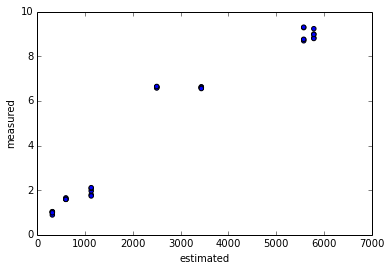

In [36]:
df = pd.DataFrame({'measured': measured_data, 'estimated': est_data}, columns=['measured', 'estimated'])
help(df.plot.scatter)
df.plot.scatter(x='estimated', y='measured')

In [39]:
all_experiments[10]

Experiment(wload_name='two_big', wload=<wlgen.rta.RTA object at 0x7f7df9091550>, conf={'dtb': None, 'kernel': None, 'tag': 'energy_aware', 'flags': 'ftrace', 'sched_features': 'ENERGY_AWARE'}, iteration=1, out_dir='/home/brejac01/sources/lisa/results/20170103_173842/rtapp:energy_aware:two_big/1')

In [44]:
t = scs[2]()

In [47]:
trace = t.get_trace(all_experiments[10])
import trappy
trappy.plotter.plot_trace(trace.ftrace)

Maximum estimated system energy: 1725


In [38]:
df

,measured,estimated
0,0.890649,319.091561
1,1.013924,319.091561
2,1.028837,319.091561
3,1.036942,319.091561
4,0.986021,319.091561
5,1.620555,601.876982
6,1.653341,601.876982
7,1.592385,601.876982
8,1.590199,601.876982
9,1.586461,601.876982


In [37]:
df.corr()

,measured,estimated
measured,1.00000,0.96297
estimated,0.96297,1.00000
